In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image, ImageOps
import os
import json
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

import torch.optim as optim

import cv2

import random
import numpy as np
    
import matplotlib.pyplot as plt

In [11]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [12]:
#### DEFINE DataLoader ####
class data(Dataset):
    def __init__(self, path):
        self.path = path  # check if exists
        self.files = os.listdir(path)

    # the function returns length of data
    def __len__(self):
        return len(self.files)

    # gives one item at a time
    def __getitem__(self, index):
        convert_tensor = transforms.ToTensor()
        convert_float = transforms.ConvertImageDtype(torch.float)

        filename = self.files[index]
        DatasetItem = json.load(open(os.path.join(self.path, filename)))

        src = cv2.imread(DatasetItem["src"], cv2.IMREAD_GRAYSCALE)
        src = cv2.resize(src, (128, 128))
        src = convert_tensor(src)

        dst = cv2.imread(DatasetItem["dst"], cv2.IMREAD_GRAYSCALE)
        dst = cv2.resize(dst, (128, 128))
        dst = convert_tensor(dst)

        transoformMat = np.matrix(DatasetItem["transformation"])

        # conver matrix to points
        points = [
            [0, 0, 1],
            [1440, 1440, 1],
            [0, 1440, 1],
        ]
        warpedPoints = np.matmul(points, transoformMat.transpose(), dtype=np.float32)

        # return values
        stacked = torch.stack((src, dst))
        return stacked, torch.from_numpy(warpedPoints[:, 0:-1].flatten()), DatasetItem


In [13]:
#### DEFINE Neural Network ####
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self._to_linear = None

        # 2 input image channel, 64 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(2, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        self.conv7 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv8 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        self.fc9 = nn.Linear(32768, 1024)

        self.fc10 = nn.Linear(1024, 6)

    def convs(self, x):
        # max pooling over 2x2
        # two conv layers
        x = self.conv1(x)
        x = self.conv2(x)

        # max pooling
        x = F.max_pool2d(x, 2)

        # two conv layers
        x = self.conv3(x)
        x = self.conv4(x)

        # max pooling
        x = F.max_pool2d(x, 2)

        # two conv layers
        x = self.conv5(x)
        x = self.conv6(x)

        # max pooling
        x = F.max_pool2d(x, 2)

        # two conv layers
        x = self.conv7(x)
        x = self.conv8(x)
            
        return x

    def forward(self, x):

        self.convs(x)
        x = x.view(-1, x[0].shape[0] * x[0].shape[1] * x[0].shape[2])

        # two linear layers
        x = self.fc9(x)
        x = self.fc10(x)
        
        return x


In [14]:
#### Create data ####
Dataset = data('.\\..\\Data\MachineData')
train_set, val_set = torch.utils.data.random_split(Dataset, [Dataset.__len__() - 30, 30])
train_dataloader = DataLoader(train_set, batch_size=50, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=1, shuffle=True)

net = Net().to(device)

loss_function = nn.MSELoss()

optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.1)

Epochs = 16
# Training
for epoch in range(Epochs):
    for dataBatch in train_dataloader:
        images, groundTruths, _ = dataBatch
        images, groundTruths = images.to(device), groundTruths.to(device)

        optimizer.zero_grad()

        outputs = net(images.view(-1, 2, 128, 128)) 

        loss = loss_function(outputs, groundTruths.view(-1,6))
        loss.backward() 
        optimizer.step() 
    
    print(f"Epoch: {epoch}. Loss: {loss}")

Epoch: 0. Loss: 306339.0625
Epoch: 1. Loss: 151888.5625
Epoch: 2. Loss: 213038.921875
Epoch: 3. Loss: 46846.125
Epoch: 4. Loss: 101737.078125
Epoch: 5. Loss: 483353.9375
Epoch: 6. Loss: 98602.546875
Epoch: 7. Loss: 68976.2734375
Epoch: 8. Loss: 43522.85546875
Epoch: 9. Loss: 67657.71875
Epoch: 10. Loss: 32480.302734375
Epoch: 11. Loss: 36002.9765625
Epoch: 12. Loss: 15953.3857421875
Epoch: 13. Loss: 16853.70703125
Epoch: 14. Loss: 20473.78125
Epoch: 15. Loss: 93382.40625


In [15]:
iterations = []
with torch.no_grad():
        for dataBatch in val_dataloader:
                images, groundTruths, DataFiles = dataBatch
                images, groundTruths = images.to(device), groundTruths.to(device)
                outputs = net(images.view(-1, 2, 128, 128)) 

                loss = loss_function(outputs, groundTruths.view(-1,6))
                iterations.append({ "batch": dataBatch, "outputs":outputs, "loss": loss})

In [87]:
iteration = random.choice(iterations)
im, gt, DataFiles = iteration["batch"]

np.set_printoptions(precision=3, suppress=True)

print(f"Ground Truth :\n {np.array(gt[0].view(3,2))}")
print(f"Transofrm    :\n {np.array(iteration['outputs'][0].view(3,2).cpu())}")
print(f"loss: {iteration['loss']}")

Ground Truth :
 [[ 259.491  283.508]
 [1202.814 1274.607]
 [ 334.366 1251.389]]
Transofrm    :
 [[ 271.459  251.37 ]
 [1266.169 1353.561]
 [ 304.96  1380.564]]
loss: 4829.1220703125


{'src': ['.\\..\\Data\\DownwardDog\\Images\\044.png'], 'dst': ['.\\..\\Data\\DownwardDog\\Images\\000.png'], 'transformation': [[tensor([0.6031], dtype=torch.float64), tensor([0.0520], dtype=torch.float64), tensor([259.4906], dtype=torch.float64)], [tensor([0.0161], dtype=torch.float64), tensor([0.6721], dtype=torch.float64), tensor([283.5085], dtype=torch.float64)], [tensor([0.], dtype=torch.float64), tensor([0.], dtype=torch.float64), tensor([1.], dtype=torch.float64)]]}


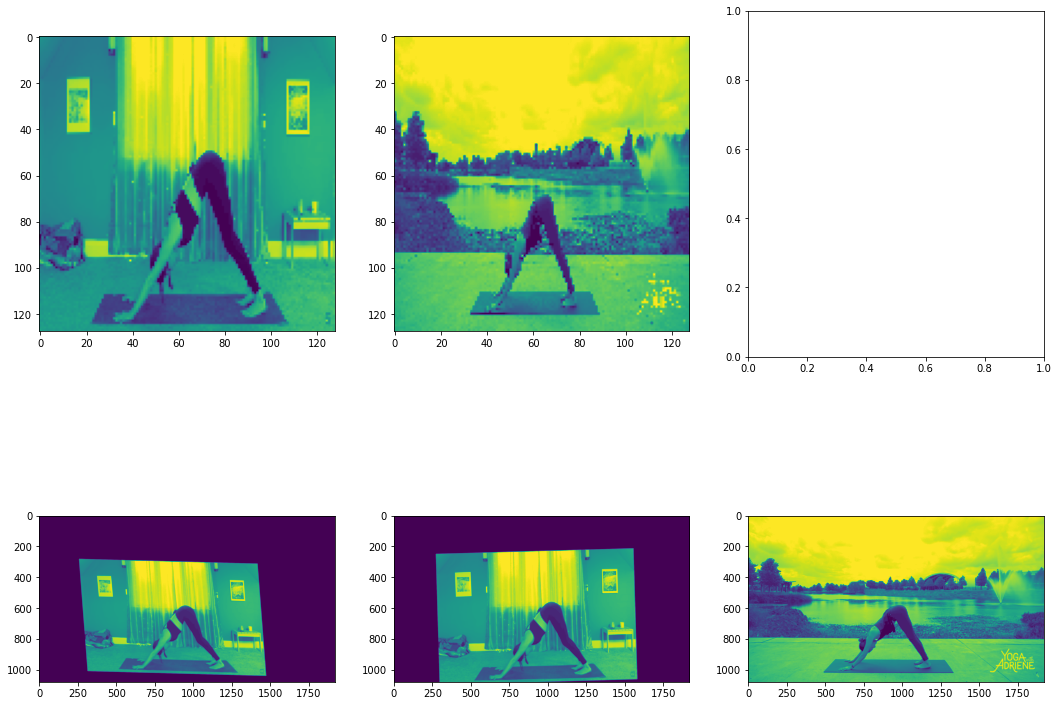

In [90]:
print(DataFiles)
src = cv2.imread(DataFiles['src'][0], cv2.IMREAD_GRAYSCALE)
dst = cv2.imread(DataFiles['dst'][0], cv2.IMREAD_GRAYSCALE)

groundPoints = np.array(gt.view(3,2))
# groundPoints = np.concatenate( (groundPoints, [[1], [1], [1],]), axis=1)

outputPoints = np.array(iteration['outputs'][0].view(3,2).cpu())
# outputPoints = np.concatenate( (outputPoints, [[1], [1], [1],]), axis=1)

srcPoints = np.array([ [0, 0], [1440, 1440], [0, 1440], ]).astype(np.float32)

fig, axes = plt.subplots(2, 3, figsize=(18, 14))

# Ground Truth
gtTransform = cv2.getAffineTransform(srcPoints, groundPoints)
warped = cv2.warpAffine(src, gtTransform, (1920, 1080))

axes[1][0].imshow(warped)

# Network Result
outputTransform = cv2.getAffineTransform(srcPoints, outputPoints)
warped = cv2.warpAffine(src, outputTransform, (1920, 1080))
axes[1][1].imshow(warped)

# Taget
axes[1][2].imshow(dst)

# Network Imputs
axes[0][0].imshow(im[0][0].view(128,128))
axes[0][1].imshow(im[0][1].view(128,128))